In [5]:
# Preparación
# Subir a /content lib.zip
!unzip lib.zip

Archive:  lib.zip
replace lib/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
# Subir a Drive la carpeta data a una carpeta en el raíz y llamarla remote-sensing-data
# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Directorios
data_in = "/content/drive/MyDrive/remote-sensing-data/010_in/"
data_out = "/content/drive/MyDrive/remote-sensing-data/990_out/"

In [8]:
import lib.remote_sensing as rm

import numpy as np

# Clasificación supervisada y no supervisada de coberturas terrestres mediante imágenes de satélite

En esta práctica vamos a ver un ejemplo de sesión de trabajo con base en __Numpy__, en la que aplicaremos una técnica de clasificación no supervisada (**clústeres K**) y otra supervisada (**Random Forest**), con el objetivo de discriminar distintas coberturas terrestres a partir de una imagen multiespectral captada por la familia de satélites Landsat 8.

La imagen es del sur de la provincia de Cádiz, abarcando aproximadamente desde Rota hasta Chiclana de la Frontera, y fue adquirida el 23 de Junio de 2016.

# La serie Landsat 8

Landsat es una serie de satélites de observación terrestre de propósito general que lleva funcionando desde los años 70. La serie actual es la 8. Los Lansat 8 son satélites de baja órbita heliosincrónica con la siguiente dotación sensorial:



## Sensor OLI (Operational Land Imager)

|Banda	                                |Longitud de onda (micrometros)|Resolución (metros)|
|--|:--:|:--:|
|Band 1 - Ultra Blue (coastal/aerosol)	|0.435 - 0.451|30|
|Band 2 - Blue	                        |0.452 - 0.512|30|
|Band 3 - Green	                        |0.533 - 0.590|30|
|Band 4 - Red	                        |0.636 - 0.673|30|
|Band 5 - Near Infrared (NIR)	        |0.851 - 0.879|30|
|Band 6 - Shortwave Infrared (SWIR) 1	|1.566 - 1.651|30|
|Band 7 - Shortwave Infrared (SWIR) 2	|2.107 - 2.294|30|
|Band 8 - Panchromatic	                |0.503 - 0.676|15|
|Band 9 - Cirrus	                    |1.363 - 1.384|30|


## Sensor TIRS (Thermal InfraRed Sensor)

|Banda                                  |Longitud de onda (micrometros)|Resolución (metros)|
|--|--|--|
|Band 10 - Thermal Infrared (TIRS) 1	|10.60 - 11.19|100|
|Band 11 - Thermal Infrared (TIRS) 2	|11.50 - 12.51|100|


Recordemos cómo es la estructura del espectro electromagnético:

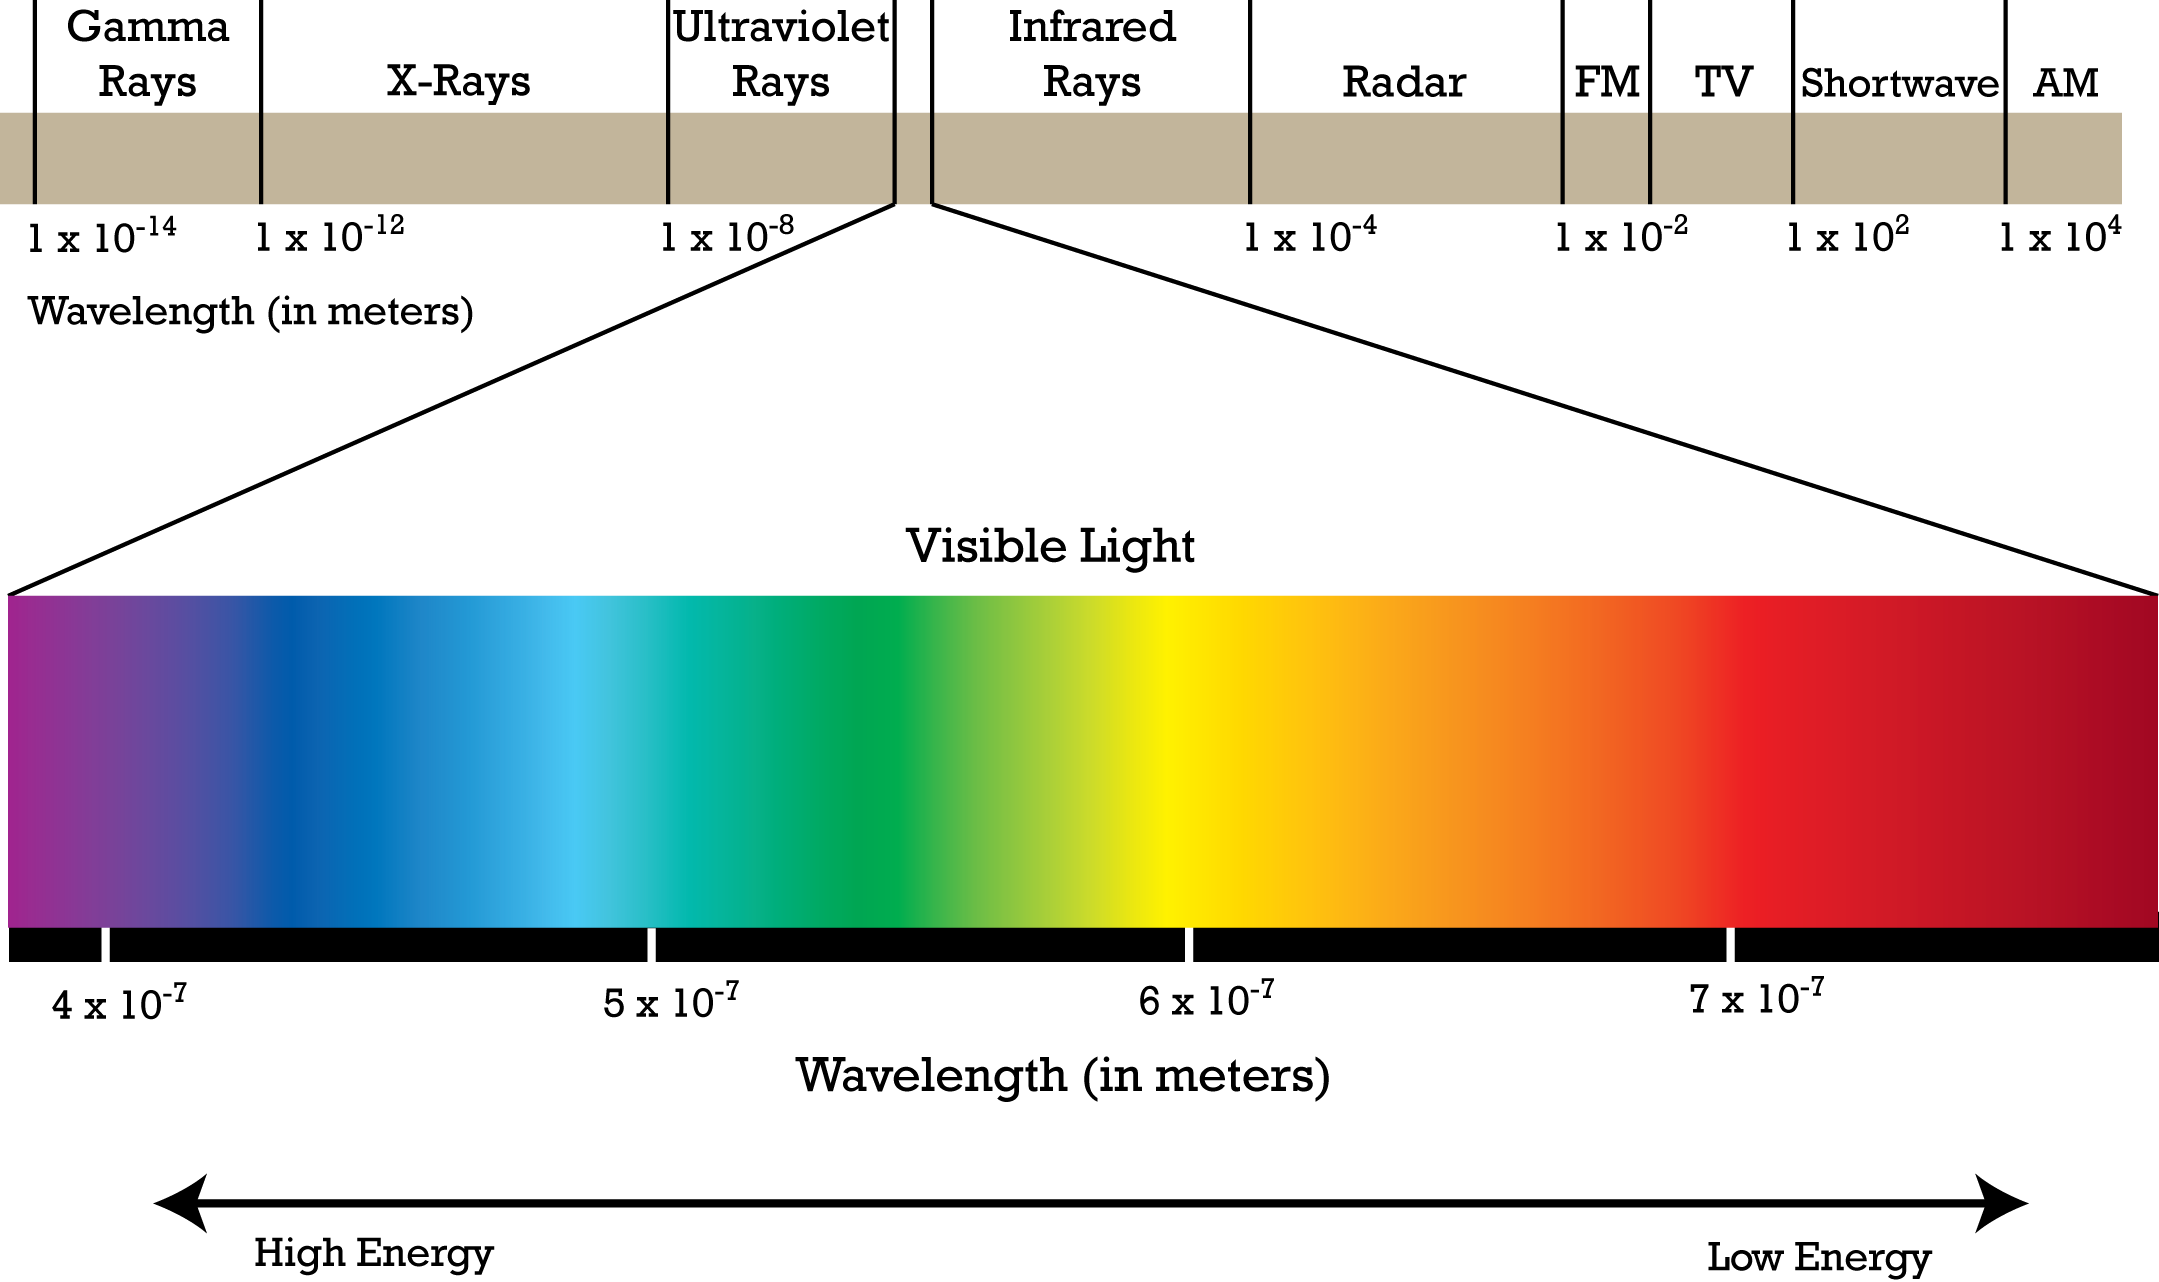

la luz visible está entre los 400 (azul) y los 700 (rojo) nanómetros.


# Bandas

Las imágenes se sirven en formato de una imagen de tipo TIFF por cada banda. Estas imágenes están georreferenciadas, es decir, están situadas con precisión sobre la superficie de la tierra, aunque en este ejercicio prescindiremos del tratamiento georreferenciado debido a que añade un factor de complejidad alto adicional.

Vamos a examinar cómo es una banda individual por dentro. Cargamos, por ejemplo, la banda del azul:

In [9]:
blue = rm.read_image(data_in + "b_2-blue.tif")

Numpy ha transformado la imagen en una matriz numérica en memoria, que se puede consultar. El resultado no es muy vistoso ya que Numpy nos muestra las "esquinas" de la matriz, que están todas a valor nulo:

In [10]:
blue

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

Podemos consultar las dimensiones y forma de la matriz:

In [11]:
blue.size

3251187

La matriz tiene 3.2 mega píxels. Sus dimensiones, en píxeles:

In [12]:
blue.shape

(1333, 2439)

Aquí un pixel que tiene datos. Los datos radiométricos (reflectancia de la superficie de la tierra para cada píxel de la imagen en la longitud de onda sensible de la banda) están normalizados, para facilitar su uso, entre 0 (ausencia de radiación en esa frecuencia) y 1 (sensor saturado de radiación):

In [13]:
blue[ 1000, 2000 ]

0.100978084

Visualicemos la imagen gracias a la librería de visualización matemática MatPlotLib:

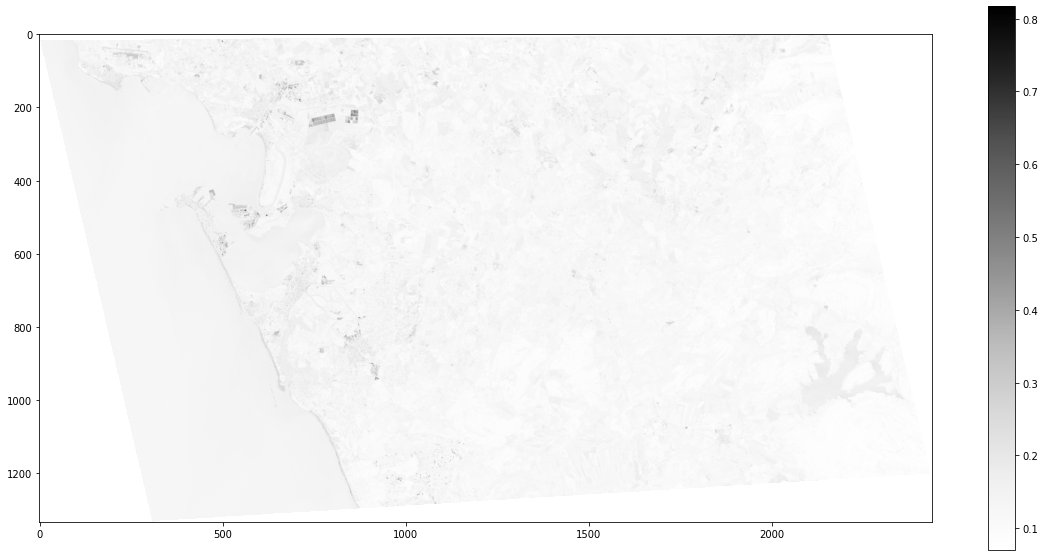

In [14]:
rm.matplotlib_show_image(blue, savefile=data_out + "010-banda_azul")

La imagen, al mostrar sus valores originales de reflectancia, no tiene suficiente contraste. Existen muchas técnicas en tratamiento de imágenes para darle contraste a una imagen que no la tiene. Aplicamos uno llamado equalización adaptativa, que suele dar muy buenos resultados:

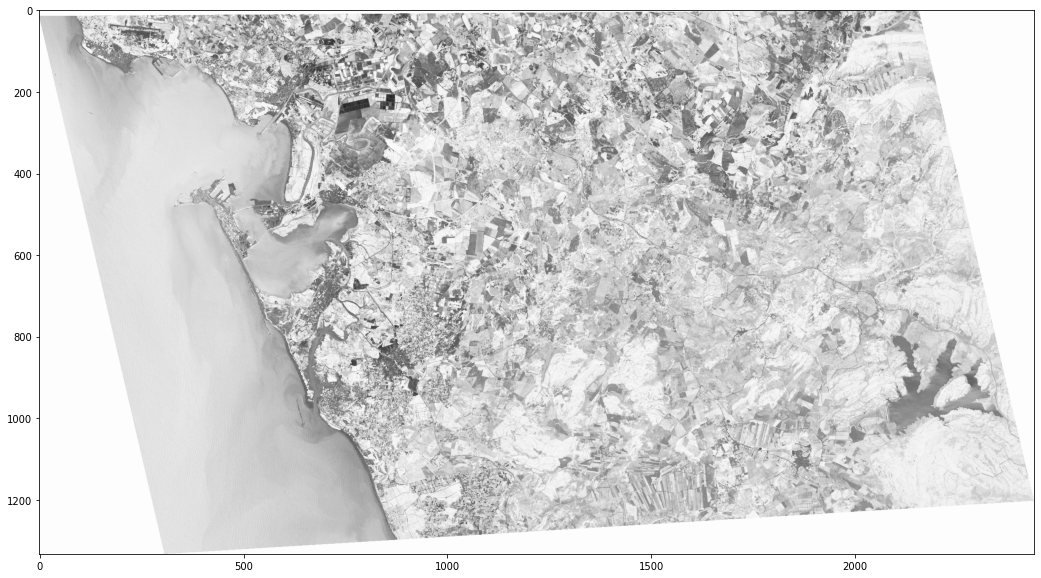

In [15]:
rm.matplotlib_show_eq_image(blue, savefile=data_out + "020-azul_eq")

# Creación de los vectores de reflectancia de cada pixel

Sin embargo, las imágenes compuestas por bandas individuales no son muy útiles. Estos juegos de datos tienen muchas aplicaciones cuando se analizan todas las bandas a la vez con técnicas de análisis multivariante. Por lo tanto, lo que necesitamos hacer a continuación es crear, con Numpy, una imagen multicapa, concretamente compuesta por las 7 bandas del sensor, de forma que cada píxel de la imagen tenga un valor de reflectividad en cada longitud de onda:

In [16]:
scene = rm.stack_images("scene.npy", 
    data_in + 'b_1-ultrablue.tif',
    data_in + 'b_2-blue.tif',
    data_in + 'b_3-green.tif',
    data_in + 'b_4-red.tif',
    data_in + 'b_5-nir.tif',
    data_in + 'b_6-swir1.tif',
    data_in + 'b_7-swir2.tif'
)

In [17]:
scene.shape

(1333, 2439, 7)

Como se puede comprobar, el juego de datos completo, llamado en este programa **scene**, tiene tres dimensiones:

- la 0, la coordenada X del píxel
- la 1, la coordenadas Y
- la 2, el valor radiométrico en cada una de las bandas consideradas

Podemos obtener los valores de reflectancia para un píxel cualquiera de la imagen:

In [18]:
scene[1000, 2000, :]

array([0.11785097, 0.10097808, 0.09756462, 0.0949721 , 0.26637992,
       0.22178884, 0.14507227], dtype=float32)

# Composiciones de color

Una de las primeras fases exploratorias en teledetección es la realización de composiciones de color. Es una técnica puramente visual pero que ayuda mucho a hacerse una idea de la estructura de la imagen.

La técnica consiste en aplicar a los canales cromáticos aditivos de la pantalla del ordenador, que son rojo, verde y azul (RGB), una estructura de color procedente de las bandas distinta a esta, con "colores" (longitudes de onda) no perceptibles por el ojo humano, como por ejemplo el infrarrojo. De esta manera, se consiguen destacar muy fácilmente fenómenos terrestres de otros que con las frecuencias naturales del ojo humano no son tan evidentes.

Recordemos que cada pixel tiene siete bandas espectrales: ultra blue, azul, verde, rojo, IR cercano (NIR), IR onda corta 1 (SWIR1) y 2 (SWIR2). Vamos a realizar una primera composición de color. Esta se llama "color verdadero" porque se pretende simular precisamente eso: el verdadero color que percibiría el ojo de un astronauta si mirara la escena. Esto se consigue, lógicamente, aplicando la longitud de onda del azul, verde y rojo a los canales cromáticos correspondientes de la pantalla del ordenador.

Lo hacemos haciendo una selección de las bandas de la escena, con un selector Numpy. Tenemos que tener en cuenta que los índices Numpy comienzan en cero, así que la correspondencia bandas - índices de la escena Numpy es:

| Banda               | Índice de la tercera dimensión Numpy |
| ------------------- |:------------------------------------:|
| Band 1 - Ultra Blue | 0                                    |
| Band 2 - Blue	      | 1                                    |
| Band 3 - Green	    | 2                                    |
| Band 4 - Red	      | 3                                    |
| Band 5 - NIR        | 4                                    |
| Band 6 - SWIR 1	    | 5                                    |
| Band 7 - SWIR 2	    | 6                                    |

Así que, como los canales cromáticos de las imágenes se organizan en orden rojo - verde - azul, debemos seleccionar las bandas en ese orden: (3, 2, 1)

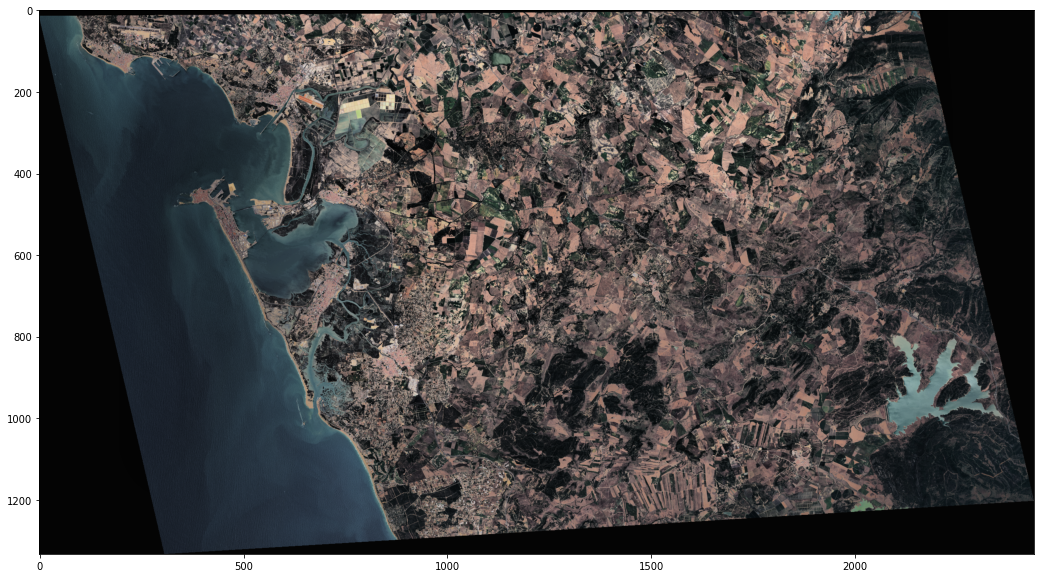

In [19]:
rm.matplotlib_false_color(scene, 3, 2, 1, savefile=data_out + "030-color_verdadero")

# Composiciones de falso color

Como ya se dijo, lo interesante es hacer composiciones de color con longitudes de onda a las que el ojo humano no es sensible. Existen varias composiciones clásicas destinadas a destacar ciertos elementos. Vamos a ver tres.

La primera y más clásica es una composición con los infrarrojos que destaca la vigorosidad de la vegetación. La composición es:

| Canal cromático | Banda |
| --------------- | ----- |
| rojo            | NIR   |
| verde           | Red   |
| azul            | Green |


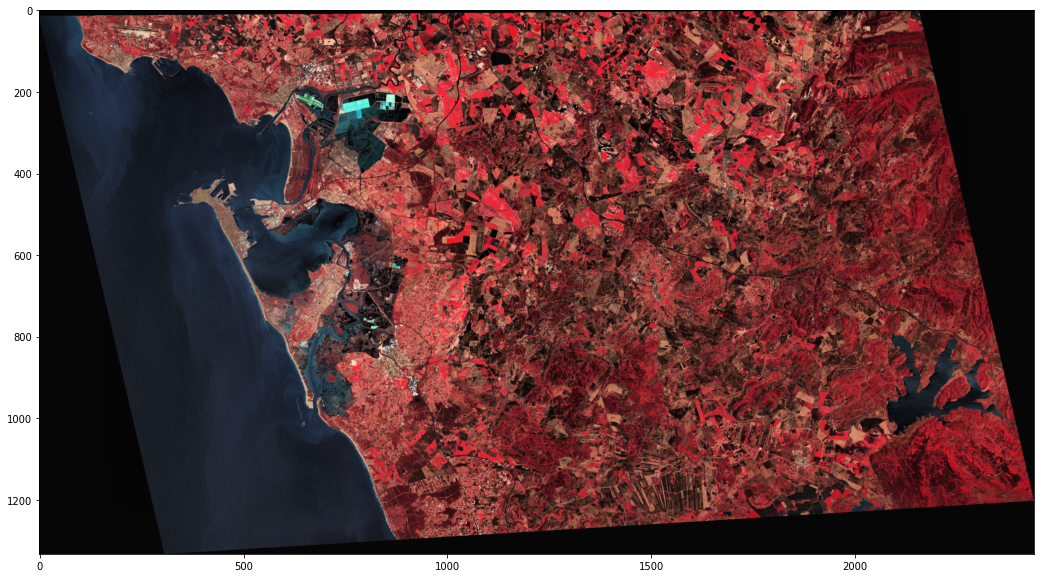

In [20]:
rm.matplotlib_false_color(scene, 4, 3, 2, savefile=data_out + "040-false_color_ir")

En esta composición, los cultivos tienen a aparecer en un verde brillante, mientras que la vegetación natural lo hace en un verde más apagado.

La última está destinada a destacar también la vegetación:

| Canal cromático | Banda |
| --------------- | ----- |
| rojo            | NIR   |
| verde           | SWIR1 |
| azul            | Blue  |

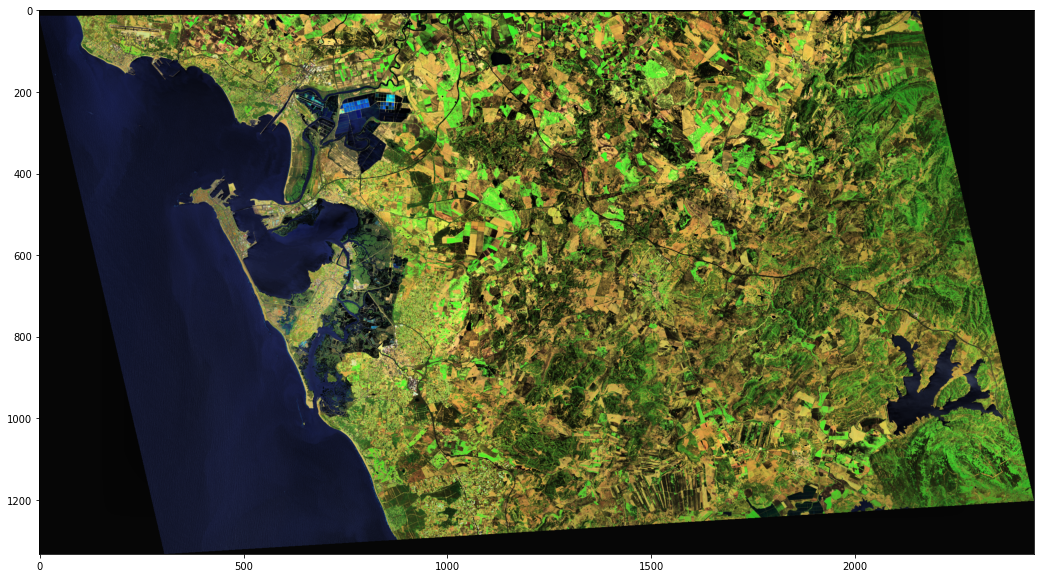

In [21]:
rm.matplotlib_false_color(scene, 5, 4, 1, savefile=data_out + "050-false_color_agr")

# Índices

Otra técnica fundamental en teledetección es la creación de índices. Los índices son fórmulas matemáticas aplicadas entre bandas con el objeto de destacar un fenómeno. Existen muchos tipos de índices para muchas aplicaciones distintas, y su obtención es una de las líneas de investigación clásica en esta disciplina.

Vamos a ver un ejemplo de índice calculando uno muy sencillo pero muy utilizado: el __índice de vegetación de diferencia normalizado (NDVI, Normalized Difference Vegetation Index)__. Este índice juega con las longitudes de involucradas en el proceso fotosintético para estimar la vigorosidad de la vegetación.

Examinemos el espectro de absorción de las dos clorofilas más usuales:

Chlorophyll_ab_spectra-en.svg

**Figure:** By Chlorophyll_ab_spectra2.PNG: Daniele Pugliesiderivative work: M0tty - This file was derived from: Chlorophyll ab spectra2.PNG:, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=20509583

Como se puede observar, las dos clorofilas tienen una gran capacidad de absorción en las bandas del azul y el rojo, y devuelve casi todo el verde (de ahí el color que percibimos en las plantas). Los fotones de las bandas roja y azul se utilizan en las dos fases del proceso fotosintético. En la imagen sólo se observa el espectro visible, pero más allá de los 700 nanómetros está el infrarrojo, y en esa franja del espectro la reflectividad de la clorofila es casi total, aunque no se vea en el esquema.

Por lo tanto, el índice juega con esa diferencia de absorción: alta en el rojo, nula en el infrarrojo cercano. Su formulación es muy sencilla:

    NDVI = (NIR - Red) / (NIR + Red)
    
Como se puede observar, es un índice normalizado, por lo que los valores que arroja están entre -1 y 1. Aproximadamente, de su interpretación se desprende lo siguiente:

| Valores         | Significado               |
| --------------- | ------------------------- |
| Por debajo de 0 | Agua                      |
| Entre 0 y 0.2   | Suelos desnudos y urbanos |
| Entre 0.2 y 0.5 | Vegetación rala           |
| Mayor de 0.5    | Vegetación vigorosa       |

In [22]:
ndvi = rm.ndvi(scene, 4, 3)

In [23]:
ndvi[1000, 2000]

0.47435135

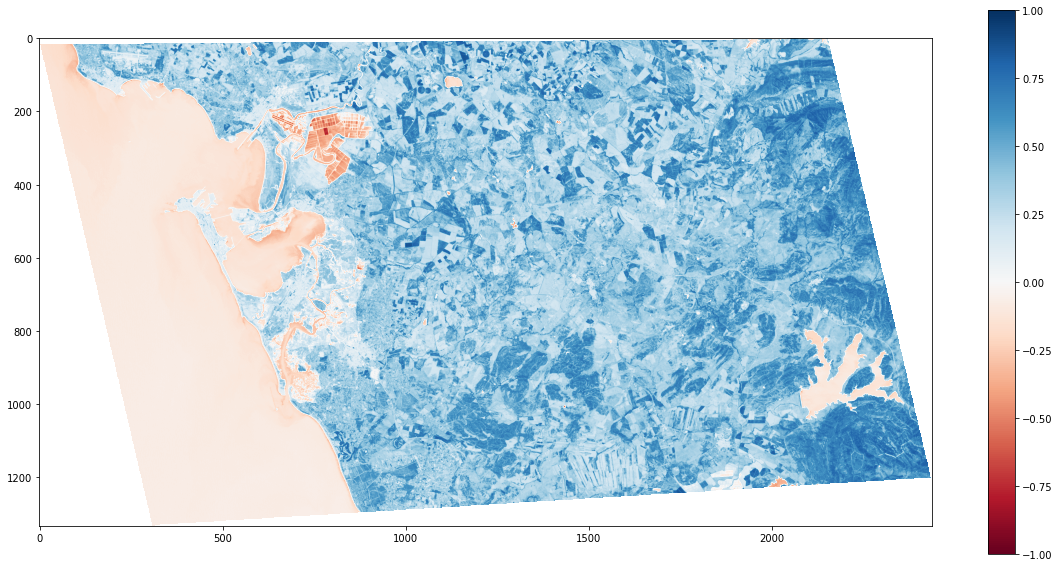

In [24]:
rm.matplotlib_show_ndvi(ndvi, savefile=data_out + "060-ndvi")

Podemos aislar los valores positivos (terrestres):

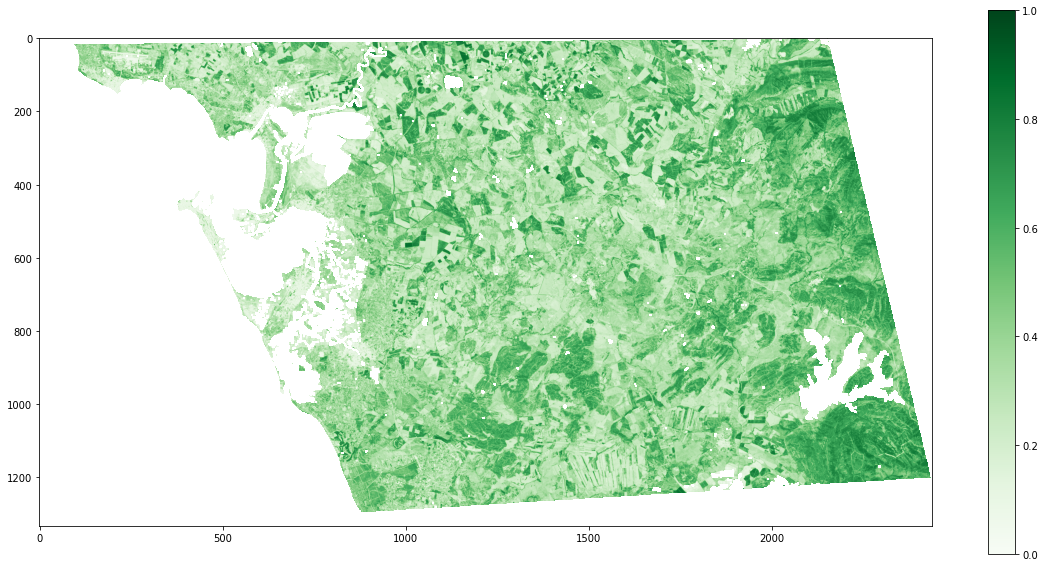

In [25]:
rm.matplotlib_show_ndvi_positive(ndvi, savefile=data_out + "070-ndvi_positive")

Y los valores negativos (agua):

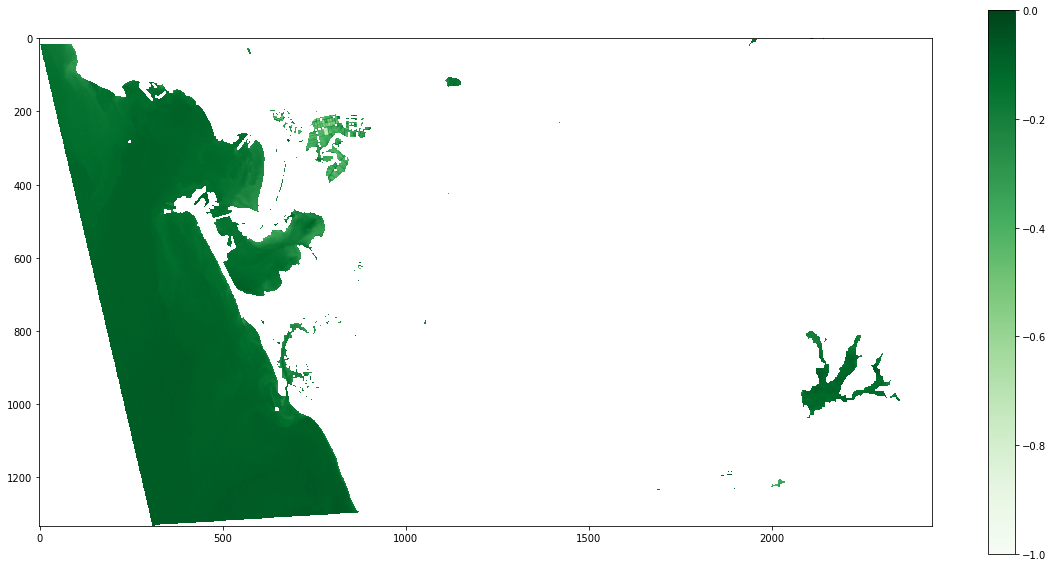

In [26]:
rm.matplotlib_show_ndvi_negative(ndvi, savefile=data_out + "080-ndvi_negative")

Numpy tiene una potente funcionalidad que permite aplicar de una forma ultraeficiente cualquier lógica de selección, filtro o procesamiento a todos los píxeles de una imagen. Vamos a clasificar los valores de NDVI en los cuatro rangos nombrados anteriormente:

| Valores         | Significado               |
| --------------- | ------------------------- |
| Por debajo de 0 | Agua                      |
| Entre 0 y 0.2   | Suelos desnudos y urbanos |
| Entre 0.2 y 0.5 | Vegetación rala           |
| Mayor de 0.5    | Vegetación vigorosa       |

In [27]:
ndvi_reclass = rm.reclassify_ndvi(ndvi)

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in ndvi_reclassify (vectorized)
  outputs = ufunc(*inputs)


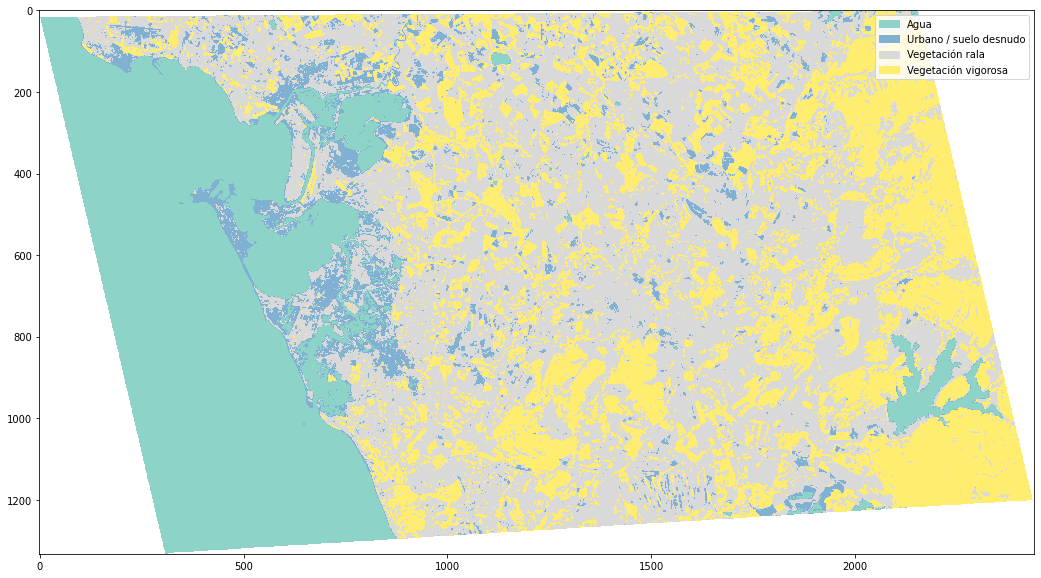

In [28]:
rm.matplotlib_show_ndvi_classes(ndvi_reclass, savefile=data_out + "090-ndvi_clases")

Lo cual nos permite extraer estadísticas de superficie de cada unos de ellos, en km2, sabiendo que los píxeles tienen 30x30 metros:

In [29]:
rm.ndvi_stats(ndvi_reclass)

array([ 597.2157,  152.5518, 1172.691 ,  530.2143])

# Un ejemplo de clasificación no supervisada: Clústeres K

La clusterización K es una técnica de clasificación de información multidimensional no asistida, es decir, que el algoritmo intenta establecer una diferenciación natural en un número variables de clases a partir de la semejanza (clustering) de las cualidades multidimensionales de una muestra de los datos.

Para ello, el algoritmo elige al azar, dentro del espacio multidimensional en el que se mueven los datos (en este caso, 7 dimensiones radiométricas) un número N de núcleos (kernels) base para cada categoría. La posición de estos núcleos se va reajustando poco a poco por medidas de cercanía al conjunto de los datos de muestra hasta que llega un momento que ya no se mueven más, dándose por terminado el entrenamiento:

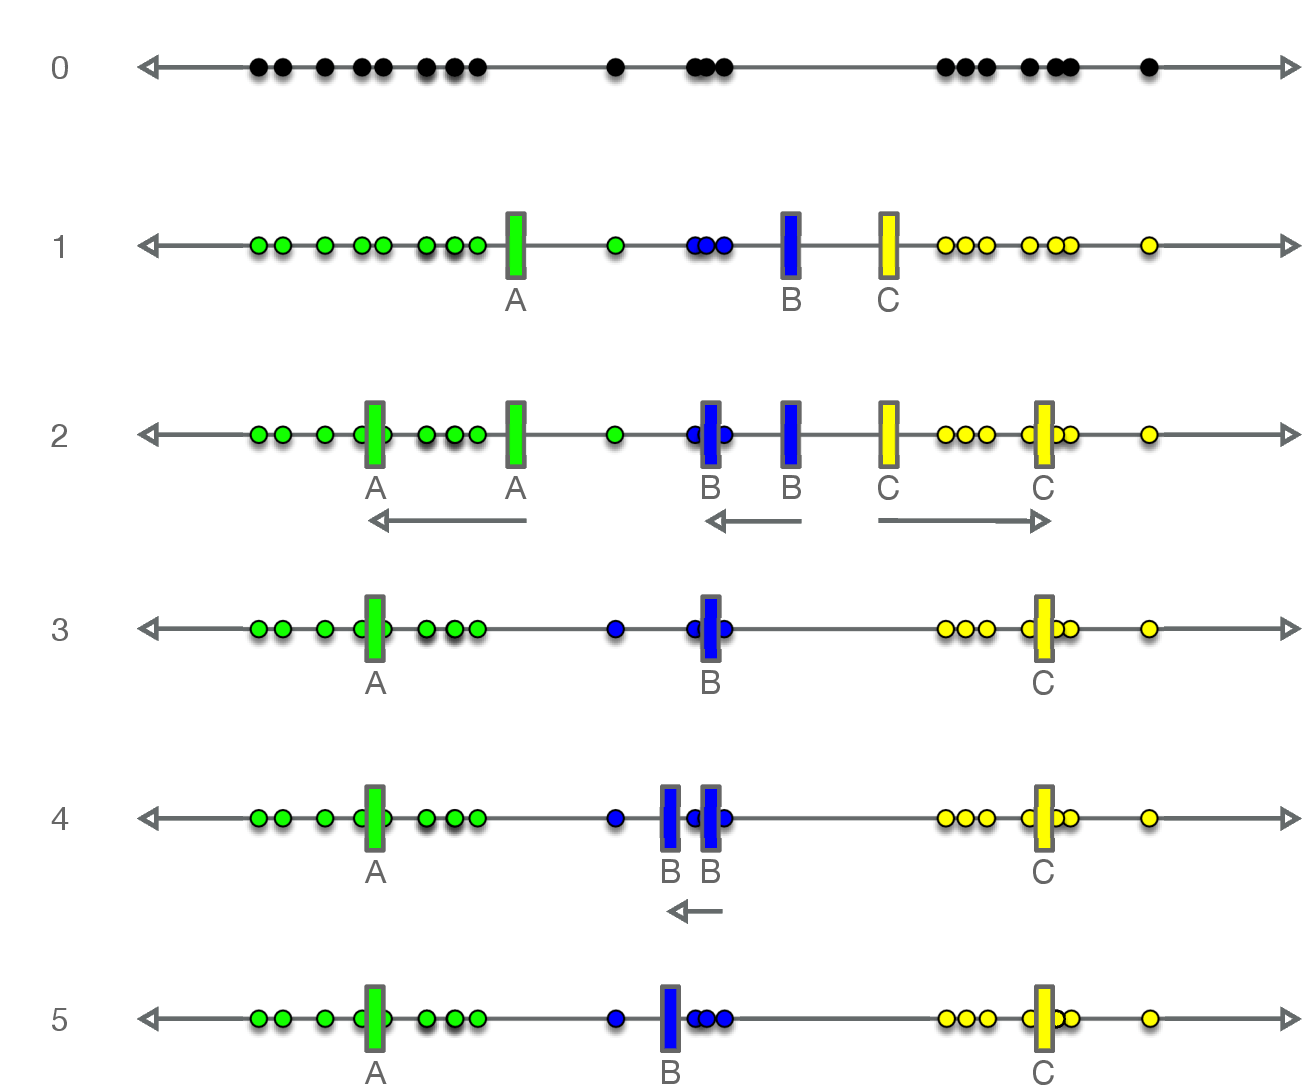

Posteriormente, nuevos datos se clasifican, en función de los núcleos encontrados durante el entrenamiento, por cercanía al núcleo más cercano.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/content/lib/remote_sensing.py:389: UserWarning: FixedFormatter should only be used together with FixedLocator
  signatures.set_xticklabels(labels=[ "dd", "Ultra Blue", "Blue", "Green", "Red", "NIR", "SWIR 1", "SWIR 2" ])


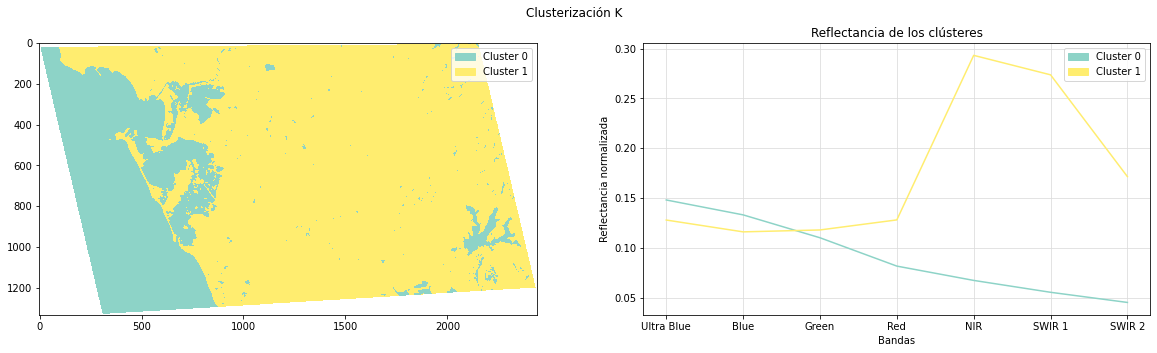

In [30]:
clusters = 2

kmeans = rm.k_means(scene, clusters, samples=30000)

rm.matplotlib_show_kmeans(kmeans, clusters, savefile=data_out + "100-kmeans")

# Un ejemplo de clasificación supervisada: Random Forest

A diferencia del anterior K-Means, el **Random Forest** es un método de clasificación supervisada. Esto quiere decir que, durante el entrenamiento, se le proporciona al algoritmo una muestra de datos que son característicos de las categorías de datos que se quieren discriminar.

En nuestro caso, por ejemplo, nuestro objetivo es intentar discriminar las siguientes coberturas terrestres:

- pantanos
- oceano
- suelo / urbano
- aguas litorales
- vegetación vigorosa
- arena
- marismas
- vegetación rala

Para entrenar el algoritmo, se han seleccionado varias zonas cuadrangulares de píxeles por cada cobertura que se sabe a ciencia cierta que pertenecen a estas categorías (por fotointerpretación, es decir, por el estudio visual de fotos aéreas).

**Random Forest** forma parte de un subgrupo de algoritmos de ML llamado **Ensemble**, ya que la decisión de la clasificación de un dato nuevo se lleva a cabo por un consenso por mayoría de varios elementos de decisión a los que se les solicita la clasificación de ese nuevo dato. En este caso, esos elementos de decisión en los que se basa este algoritmo son **árboles de decisión**.

Procesando clase pantano
Procesando clase oceano
Procesando clase suelo / urbano
Procesando clase aguas litorales
Procesando clase vegetación vigorosa
Procesando clase arena
Procesando clase marisma
Procesando clase vegetación rala


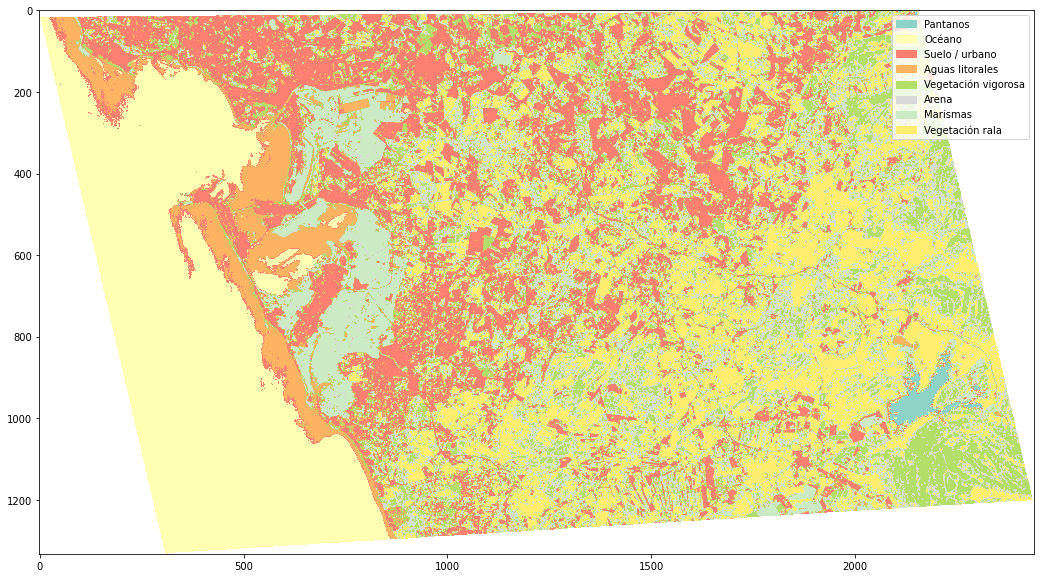

In [31]:
random_forest = rm.random_forest(scene)

rm.matplotlib_show_random_forest(random_forest, savefile=data_out + "110-random_forest")